# Dynamic Volume-Return Relation of Individual Stocks

In the [article](https://www.jstor.org/stable/1262690) they downloaded the datasets of NYSE and AMEX from CRSP, but since we wasn't able to do it, since it requires some permits, we decided to download them from the Yahoo Finance site.

More specifically we download the **AXP** and **NYA** datasets with a time range of **5 years**.

In [11]:
# Useful install in order to use OLS method
# !pip install statsmodels

In [12]:
# Here we have useful import
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import datetime as dt

# Using plotly.express
import plotly.express as px
import plotly.graph_objects as go

import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.style.use('seaborn')

# OLS method
import statsmodels.api as sm

## Set constant variable

In [13]:
DIR_DATA = "../dataset/paper_dataset/"

# Tickers for CSV files
TICKERS = ["AXP", "NYA"]

## Functions

In [14]:
# Load the datasets
def get_dataframe(ticker):
    FORMAT_FILE = "{}.csv"
    df = pd.read_csv(DIR_DATA + FORMAT_FILE.format(ticker))
    # fill eventual NaN values
    df = df.fillna(method = 'ffill').fillna(method = 'bfill')
    return df

### Return the Daily Return

In [15]:
def get_daily_returns(df, col):
    """Compute the returns of the assets in the dataset.

    Args:
        df (_type_): dataset with the prices of the assets.
    """
    # Compute the returns as in the paper
    # Notice that the first row of the Close_Daily_Return we obtain a NaN and this is
    # correct because there is nothing before it
    
    df[col+"_Daily_Returns"] = (df[col].pct_change())*100

    # Drop the NaN values
    df.dropna(inplace=True)

    # Plot the Daily Returns
    fig,ax=plt.subplots(figsize=(12,6))
    ax.spines[['top','right','left','bottom']].set_visible(False)
    plt.plot(df['Close_Daily_Returns'], label = 'Daily Returns')
    plt.legend(loc='best')
    plt.title('Stock Daily Returns Over Time')
    plt.show()
    
    return df

### OLS

**Ordinary least squares** (OLS) regression is a method that allows us to find a line that best describes the relationship between one or more predictor variables and a response variable.

This method allows us to find the following equation:

$y = b_0 + b_1x$

where:
- y: the estimated response value
- $b_0$: the intercept of the regression line
- $b_1$: the slope of the regression line

[Source](https://www.statology.org/ols-regression-python/) of the implementation.

In [16]:
def compute_ols(data, col1, col2):
    x = data[col1]
    y = data[col2]
    # adding the constant term
    x = sm.add_constant(x)
    # performing the regression
    # and fitting the model
    result = sm.OLS(y, x).fit()

    # printing the summary table
    print(result.summary())

In [17]:
def plot_ols(data, col1, col2):
    # find line of best fit
    a,b = np.polyfit(data[col1], data[col2], 1)
    # add points to plot
    plt.scatter(data[col1], data[col2], color='purple')
    # add line of best fit to plot
    plt.plot(data[col1], a*data[col1]+b)
    #add fitted regression equation to plot
    plt.text(1, 90, 'y = ' + '{:.3f}'.format(b) + ' + {:.3f}'.format(a) + 'x', size=12)

    #add axis labels
    plt.xlabel('Daily Returns')
    plt.ylabel('Volume')

### Main Function

In [18]:
def see_ticker_stat(ticker):
    df = get_dataframe(ticker)
    get_daily_returns(df, "Close")
    compute_ols(df, "Close_Daily_Returns", "Volume")
    plot_ols(df, "Close_Daily_Returns", "Volume")

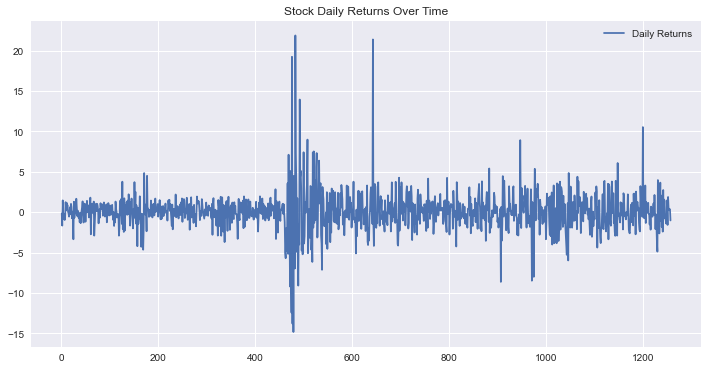

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.07550
Date:                Fri, 21 Apr 2023   Prob (F-statistic):              0.784
Time:                        16:44:46   Log-Likelihood:                -19992.
No. Observations:                1257   AIC:                         3.999e+04
Df Residuals:                    1255   BIC:                         4.000e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.823e+06   5

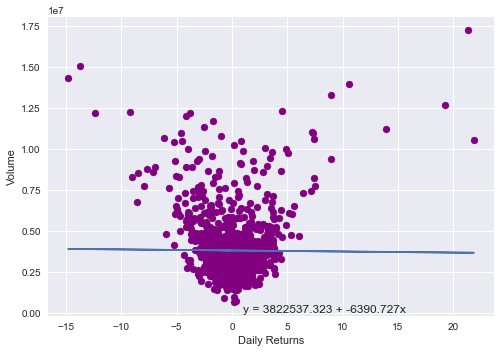

In [19]:
# AXP
see_ticker_stat(TICKERS[0])

From the **coef** column we can see the regression coefficients and can write the following fitting regression equation is:

$Score = 3.823^{06} + (-6390.7272)*(Volume)$

This means that each additional volume is associated with an average decrease of -6390 points.

The intercept value of -6390 tell us the average expected volume for a daily return.

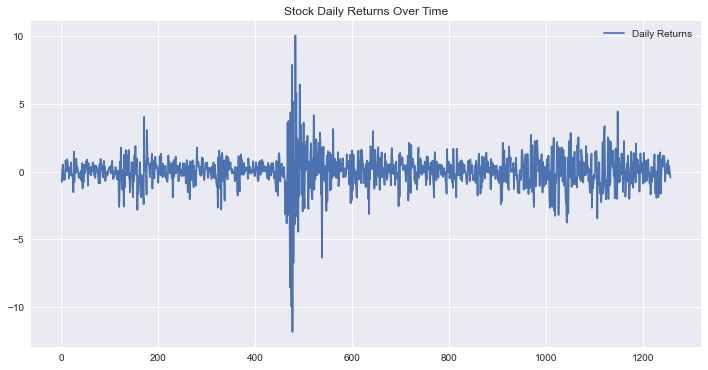

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                 Volume   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.357
Date:                Fri, 21 Apr 2023   Prob (F-statistic):            0.00391
Time:                        16:44:47   Log-Likelihood:                -27932.
No. Observations:                1257   AIC:                         5.587e+04
Df Residuals:                    1255   BIC:                         5.588e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.268e+09   3

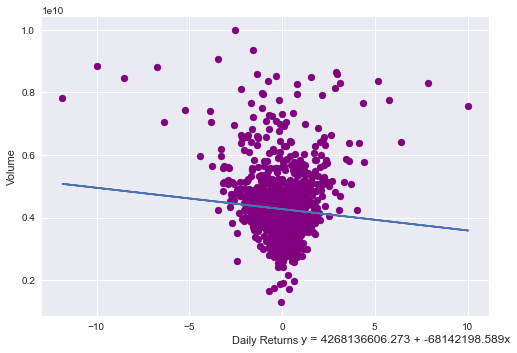

In [20]:
# NYA
see_ticker_stat(TICKERS[1])